In [ ]:
# ('◡')
# Drive (if needed): https://drive.google.com/drive/folders/1-AkPH0vVHAawvF5JcYeEx0jQ2wlT9GDV?usp=sharing
"""
imports and timing CPU vs GPU
https://saturncloud.io/blog/how-to-force-pytorch-to-use-gpu/
Specifying the Device for Models -> forces PyTorch to USE GPU when set in runtime settings

(Use PyTorch's DataParellel module for multiple GPUs, not used here)

All data/target Tensors MUST use cuda if the model does => conditional statements

For using cuda/GPU: runtime -> change runtime type -> TP4
 """
import torch
import torchvision
#for time comparison CPU vs GPU:
import time
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


In [ ]:
# load MNIST data
batch_size_train = 64
batch_size_test = 1000

# automatically split training and test data and normalize by shifting value distribution
# image = (image - mean) / standard_deviation
# image = (image - 0.1307) / 0.3081
# pin_memory may improve performance slightly
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True, pin_memory=True)

In [ ]:
# finding data dimensions
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

examples2 = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples2)
example_data.shape

torch.Size([1000, 1, 28, 28])


torch.Size([64, 1, 28, 28])

In [ ]:
# template notebook
"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation defines the model as a custom Module subclass. Whenever you
want a model more complex than a simple sequence of existing Modules you will
need to define your model this way.

Changed to use log_softmax (!= softmax, values can be negative)
"""

class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.linear1(x).clamp(min=0)
    y_relu2 = self.linear2(h_relu).clamp(min=0)
    #print("y_relu:", y_relu2)
    y_dist = torch.nn.functional.log_softmax(torch.squeeze(y_relu2))
    # y_pred = argmax(y_dist)
    return y_dist



In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = batch_size_train, 28 * 28, 100, 10

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)
if torch.cuda.is_available():
    model.to(device)
    print("Model moved to GPU")
else:
    print("GPU is not available, using CPU instead")

Model moved to GPU


In [ ]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.

# MSELoss won't work since labels contain multiple classes designated ==0/1
#loss_fn = torch.nn.MSELoss(reduction='sum')

momentum = 0.5
learning_rate = 1e-4
n_epochs = 50
log_interval = 10

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)

# the following are a single training epoch and old loss functions,
# still here for comparison, delete later:

"""
for batch_idx, (data, target) in enumerate(train_loader):
  print(data.shape)
  print(target.shape)
  data_flat = torch.flatten(data, start_dim=2)
  target_flat = torch.flatten(target, start_dim=0)
  print(data_flat.shape)
  print(target_flat.shape)
  # Forward pass: Compute predicted y by passing x to the model
  y_pred = model(data_flat)
"""

  # Compute and print loss
  #print('ypredshape', y_pred.shape, ' target_flatshape', target_flat.shape)
  #loss = loss_fn(y_pred, target_flat)
  #print(batch_idx, loss.item())

  # Zero gradients, perform a backward pass, and update the weights.
  #optimizer.zero_grad()
  #loss.backward()
  #optimizer.step()

'\nfor batch_idx, (data, target) in enumerate(train_loader):\n  print(data.shape)\n  print(target.shape)\n  data_flat = torch.flatten(data, start_dim=2)\n  target_flat = torch.flatten(target, start_dim=0)\n  print(data_flat.shape)\n  print(target_flat.shape)\n  # Forward pass: Compute predicted y by passing x to the model\n  y_pred = model(data_flat)\n'

In [ ]:
#new loss

#random_seed = 1
#torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    #flattened for non convolutional net:
    #using cuda (GPU) for all Tensors if available
    data_flat = torch.flatten(data.cuda() if torch.cuda.is_available() else data, start_dim=2)
    target_flat = torch.flatten(target.cuda() if torch.cuda.is_available() else target, start_dim=0)
    output = model(data_flat)
    loss = torch.nn.functional.nll_loss(output, target.cuda() if torch.cuda.is_available() else target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(model.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

Before training: 


<ipython-input-64-86f339e58448>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_dist = torch.nn.functional.log_softmax(torch.squeeze(y_relu2))
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3035, Accuracy: 1191/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302283
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309428
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.329783
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275820
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.265256
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.304845
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.297561
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.308004
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.286856
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.301938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.285993
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.294352
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.284706
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.289518
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.285518
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.285058
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.273513
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.284676
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.250052
Train Epoch: 1 [12160

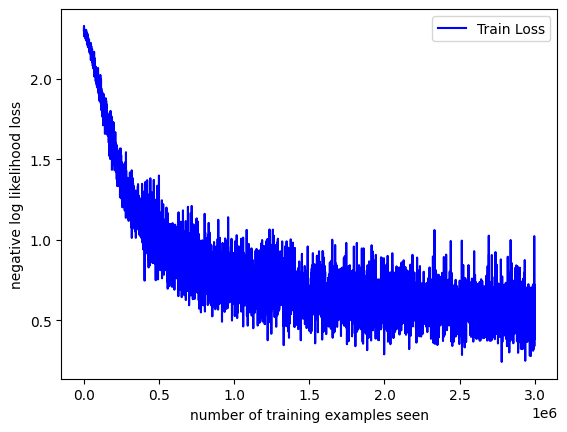

In [ ]:
import matplotlib.pyplot as plt

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      # flattening as with training data:
      data_flat = torch.flatten(data, start_dim=2, end_dim=3)
      #print('datashape', data_flat.shape)
      # ! call cuda() here as well if available to move Tensors to GPU
      if torch.cuda.is_available():
        output = model(data_flat.cuda())
        test_loss += torch.nn.functional.nll_loss(output, target.cuda(), size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.cuda().data.view_as(pred)).sum()
      else:
        output = model(data_flat)
        test_loss += torch.nn.functional.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
print('Before training: ')
test()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

------------------------------------------------------


<ipython-input-64-86f339e58448>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_dist = torch.nn.functional.log_softmax(torch.squeeze(y_relu2))



Test set: Avg. loss: 0.5459, Accuracy: 8277/10000 (83%)



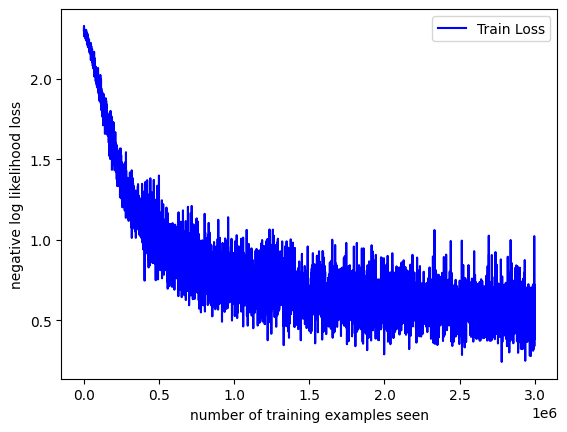

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

print('------------------------------------------------------')
test()

In [ ]:
#last step: timing
elapsed_time = time.time() - start_time
print('time', device, ': ')
print(elapsed_time)


"""
measured on google colab
------------------------------------------------------
time cpu : 1368.7707085609436
results: Test set: Avg. loss: 0.3207, Accuracy: 9101/10000 (91%)
------------------------------------------------------
time cuda : 856.7148056030273
results: Test set: Avg. loss: 0.5459, Accuracy: 8277/10000 (83%)
"""

time cuda : 
1039.617047548294


'\nmeasured on google colab\n------------------------------------------------------\ntime cpu : 1368.7707085609436\nresults: Test set: Avg. loss: 0.3207, Accuracy: 9101/10000 (91%)\n------------------------------------------------------\ntime cuda : 856.7148056030273\nresults: Test set: Avg. loss: 0.5459, Accuracy: 8277/10000 (83%)\n'